### ENd to End Memory Model
##### We see that LSTMs push the boundary a bit further compared to RNNs. But, similar to RNNs, they fail on long sequences,  displaying an abrupt decline in accuracy. We conclude that neither LSTMs or RNNs are adequate tools for handing very long sequences of facts for Question Answering. LSTMs outperform RNNs for moderately long contexts, but fail on extensive sequences.

In [49]:
from __future__ import print_function
import numpy as np
import pandas as pd
import keras
import keras.utils
from keras import layers
from keras.layers import merge
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import re


In [50]:
import os
import sys
#train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
#test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

In [51]:
def create_tokenizer(trainingdata, testdata):
    f=open(trainingdata, "r")
    text=[]

    for line in f:
        m=re.match("^\d+\s([^\.]+)[\.].*",line.rstrip())
        if m:
            text.append(m.group(1))
        else:
            m=re.match("^\d+\s([^\?]+)[\?]\s\t([^\t]+)",line.rstrip())
            if m:
                text.append(m.group(1)+' '+m.group(2))
    f.close()

    f=open(testdata, "r")
    for line in f:
        m=re.match("^\d+\s([^\.]+)[\.].*",line.rstrip())
        if m:
            text.append(m.group(1))
        else:
            m=re.match("^\d+\s([^\?]+)[\?].*",line.rstrip())
            if m:
                text.append(m.group(1))
    f.close()

    vocabulary=set([word for word in text])
    max_words = len(vocabulary)
    tokenizer = Tokenizer(num_words=max_words, char_level=False, split=' ')
    tokenizer.fit_on_texts(text)
    #max_story_len = 28
    #max_query_len = 5
    return tokenizer, max_words

In [52]:
context=0
def process_stories_n_context(filename,tokenizer,vocab_size,use_context=context):
    f=open(filename,"r")
    X=[]
    Q=[]
    y=[]
    max_story_len=0
    max_query_len=0

    for line in f:
        m=re.match("^(\d+)\s(.+)\.",line.rstrip())
        if m:
            if int(m.group(1))==1:
                story={}
            story[int(m.group(1))]=m.group(2)
        else:
            m=re.match("^\d+\s(.+)\?\s\t([^\t]+)\t(.+)",line.rstrip())
            if m:
                question=m.group(1)
                answer=m.group(2)
                answer_ids=[int(x) for x in m.group(3).split(" ")]
                facts=' '.join([story[id] for id in answer_ids])
                all_facts=' '.join([story[id] for id in story])
                facts_v=vectorize(facts,tokenizer)
                all_facts_v=vectorize(all_facts,tokenizer)

                if use_context==0:
                    vectorized_fact=facts_v
                elif use_context==-1:
                    vectorized_fact=all_facts_v
                else:
                    x=min(use_context, len(story))
                    facts=' '.join([story[id] for id in answer_ids])+' '
                    n=0
                    for id in story:
                        if n<x and id not in answer_ids:
                            facts+=story[id]+' '
                            n+=1
                    vectorized_fact=vectorize(facts,tokenizer)
                l=len(vectorized_fact)
                if l>max_story_len:
                    max_story_len=l
                vectorized_question=vectorize(question,tokenizer)
                l=len(vectorized_question)
                if l>max_query_len:
                    max_query_len=l

                vectorized_answer=vectorize(answer,tokenizer)

                X.append(vectorized_fact)
                Q.append(vectorized_question)
                answer=np.zeros(vocab_size)
                answer[vectorized_answer[0]]=1
                y.append(answer)
    f.close()

    return np.array(X),np.array(Q),np.array(y), max_story_len, max_query_len

In [53]:
def vectorize(s, tokenizer):
    vector=tokenizer.texts_to_sequences([s])
    return vector[0]

In [54]:
def create_model_nnm(trainingData, testData, context):
    #import merge

    tokenizer,vocab_size=create_tokenizer(trainingData,testData)

    X_tr,Q_tr,y_tr,max_story_len_tr, max_query_len_tr=process_stories_n_context(trainingData,tokenizer,vocab_size,use_context=context)
    X_te,Q_te,y_te, max_story_len_te, max_query_len_te=process_stories_n_context(testData,tokenizer,vocab_size,use_context=context)

    max_story_len=max(max_story_len_tr, max_story_len_te)
    max_query_len=max(max_query_len_tr, max_query_len_te)

    X_tr=pad_sequences(X_tr,max_story_len)
    Q_tr=pad_sequences(Q_tr, max_query_len)
    X_te=pad_sequences(X_te,max_story_len)
    Q_te=pad_sequences(Q_te,max_query_len)

    input = Input((max_story_len,))
    question = Input((max_query_len,))

    A= Embedding(input_dim=vocab_size,output_dim=64)
    C=Embedding(input_dim=vocab_size, output_dim=max_query_len)
    B=Embedding(input_dim=vocab_size,output_dim=64,input_length=max_query_len)

    input_A = A(input)
    input_C = C(input)
    question_B = B(question)

    input_question_match = dot([input_A, question_B], axes=(2, 2))
    Probs = Activation('softmax')(input_question_match)

    O = add([Probs, input_C])
    O = Permute((2, 1))(O)

    final_match = concatenate([O, question_B])

    size=keras.backend.int_shape(final_match)[2]
    weights = Dense(size, activation='softmax')(final_match)

    merged=layers.multiply([final_match, weights])
    answer=Flatten()(merged)

    answer = Dense(vocab_size)(answer)
    answer = Activation('softmax')(answer)

    model = Model([input, question], answer)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #model.summary()

    return X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model

#create_model_nnm(train,test,context)

In [7]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context1=0
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model1=create_model_nnm(train,test,context1)
print('Training')
history1=model1.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)
print('Evaluation for context=0')
loss1, acc1 = model1.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss1, acc1))


Instructions for updating:
Colocations handled automatically by placer.
Training
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 3s 333us/step - loss: 3.9837 - acc: 0.1826 - val_loss: 2.5808 - val_acc: 0.1710
Epoch 2/30
9000/9000 [==============================] - 2s 169us/step - loss: 2.1079 - acc: 0.1678 - val_loss: 1.8662 - val_acc: 0.1690
Epoch 3/30
9000/9000 [==============================] - 1s 150us/step - loss: 1.7156 - acc: 0.2927 - val_loss: 1.5744 - val_acc: 0.3850
Epoch 4/30
9000/9000 [==============================] - 1s 136us/step - loss: 1.4152 - acc: 0.3346 - val_loss: 1.2646 - val_acc: 0.3330
Epoch 5/30
9000/9000 [==============================] - 1s 137us/step - loss: 1.1787 - acc: 0.4707 - val_loss: 1.0822 - val_acc: 0.6670
Epoch 6/30
9000/9000 [==============================] - 2s 172us/

In [9]:
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context2=2
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model2=create_model_nnm(train,test,context2)

print('Training')
history2=model2.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=2')
loss2, acc2 = model2.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss2, acc2))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 3s 292us/step - loss: 3.9398 - acc: 0.1660 - val_loss: 2.5482 - val_acc: 0.1580
Epoch 2/30
9000/9000 [==============================] - 2s 189us/step - loss: 2.0885 - acc: 0.1638 - val_loss: 1.8647 - val_acc: 0.1840
Epoch 3/30
9000/9000 [==============================] - 1s 149us/step - loss: 1.8205 - acc: 0.1647 - val_loss: 1.7991 - val_acc: 0.1840
Epoch 4/30
9000/9000 [==============================] - 1s 166us/step - loss: 1.7857 - acc: 0.1893 - val_loss: 1.7677 - val_acc: 0.2150
Epoch 5/30
9000/9000 [==============================] - 1s 152us/step - loss: 1.7269 - acc: 0.2768 - val_loss: 1.6885 - val_acc: 0.3200
Epoch 6/30
9000/9000 [==============================] - 2s 167us/step - loss: 1.6119 - acc: 0.3000 - val_loss: 1.5541 - val_acc: 0.3200
Epoch 7/30
9000/9000 [==============================] - 2s 176us/step - loss: 1.4821 - acc: 0.2938 - val_loss: 1.4413 - val_acc

In [12]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')


context3=4
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model3=create_model_nnm(train,test,context3)

print('Training')
history3=model3.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=4')
loss3, acc3 = model3.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss3, acc3))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 3s 358us/step - loss: 3.8510 - acc: 0.1581 - val_loss: 2.5039 - val_acc: 0.1700
Epoch 2/30
9000/9000 [==============================] - 2s 193us/step - loss: 2.0724 - acc: 0.1756 - val_loss: 1.8587 - val_acc: 0.1840
Epoch 3/30
9000/9000 [==============================] - 2s 199us/step - loss: 1.8177 - acc: 0.1741 - val_loss: 1.7970 - val_acc: 0.1990
Epoch 4/30
9000/9000 [==============================] - 2s 190us/step - loss: 1.7926 - acc: 0.1848 - val_loss: 1.7879 - val_acc: 0.2240
Epoch 5/30
9000/9000 [==============================] - 2s 179us/step - loss: 1.7815 - acc: 0.2072 - val_loss: 1.7687 - val_acc: 0.2750
Epoch 6/30
9000/9000 [==============================] - 2s 184us/step - loss: 1.7553 - acc: 0.2419 - val_loss: 1.7286 - val_acc: 0.3030
Epoch 7/30
9000/9000 [==============================] - 2s 218us/step - loss: 1.6973 - acc: 0.2671 - val_loss: 1.6583 - val_acc

In [14]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')


context4=6
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model4=create_model_nnm(train,test,context4)

history4=model4.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=6')
loss4, acc4 = model4.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss4, acc4))

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 4s 429us/step - loss: 3.9828 - acc: 0.1663 - val_loss: 2.8629 - val_acc: 0.1710
Epoch 2/30
9000/9000 [==============================] - 2s 248us/step - loss: 2.2782 - acc: 0.1641 - val_loss: 1.9357 - val_acc: 0.1850
Epoch 3/30
9000/9000 [==============================] - 2s 250us/step - loss: 1.8495 - acc: 0.1720 - val_loss: 1.8084 - val_acc: 0.1850
Epoch 4/30
9000/9000 [==============================] - 2s 237us/step - loss: 1.7982 - acc: 0.1750 - val_loss: 1.7944 - val_acc: 0.1890
Epoch 5/30
9000/9000 [==============================] - 2s 244us/step - loss: 1.7924 - acc: 0.1750 - val_loss: 1.7922 - val_acc: 0.1890
Epoch 6/30
9000/9000 [==============================] - 2s 266us/step - loss: 1.7911 - acc: 0.1758 - val_loss: 1.7914 - val_acc: 0.1890
Epoch 7/30
9000/9000 [==============================] - 3s 317us/step - loss: 1.7904 - acc: 0.1753 - val_loss: 1.7910 - val_acc: 0.1890


In [57]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context5=-1
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model5=create_model_nnm(train,test,context5)
print('Training')

history5=model5.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1)

print('Evaluation for context=All')
loss5, acc5 = model5.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss5, acc5))
#pred=model.pred()

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 4s 490us/step - loss: 3.8375 - acc: 0.1612 - val_loss: 2.4896 - val_acc: 0.1710
Epoch 2/30
9000/9000 [==============================] - 2s 223us/step - loss: 2.0628 - acc: 0.1642 - val_loss: 1.8548 - val_acc: 0.1710
Epoch 3/30
9000/9000 [==============================] - 2s 263us/step - loss: 1.8164 - acc: 0.1681 - val_loss: 1.7953 - val_acc: 0.1710
Epoch 4/30
9000/9000 [==============================] - 2s 245us/step - loss: 1.7915 - acc: 0.1821 - val_loss: 1.7852 - val_acc: 0.2420
Epoch 5/30
9000/9000 [==============================] - 2s 236us/step - loss: 1.7820 - acc: 0.2184 - val_loss: 1.7676 - val_acc: 0.2720
Epoch 6/30
9000/9000 [==============================] - 2s 238us/step - loss: 1.7472 - acc: 0.2492 - val_loss: 1.7095 - val_acc: 0.2770
Epoch 7/30
9000/9000 [==============================] - 2s 240us/step - loss: 1.7057 - acc: 0.2676 - val_loss: 1.6646 - val_acc

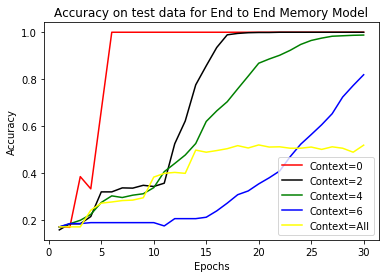

In [63]:
import matplotlib.pyplot as plt
#plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
history4_dict = history4.history
history5_dict = history5.history
acc_values1 = history1_dict['val_acc']
acc_values2 = history2_dict['val_acc']
acc_values3 = history3_dict['val_acc']
acc_values4 = history4_dict['val_acc']
acc_values5 = history5_dict['val_acc']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  acc_values1, 'b', label='Context=0',color='red')
plt.plot(epochs, acc_values2, 'b', label='Context=2', color='black')
plt.plot(epochs, acc_values3, 'b', label='Context=4', color='green')
plt.plot(epochs, acc_values4, 'b', label='Context=6', color='blue')
plt.plot(epochs, acc_values5, 'b', label='Context=All', color='yellow')
plt.title('Accuracy on test data for End to End Memory Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


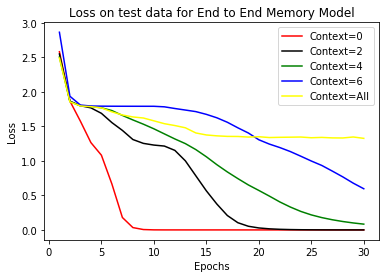

In [64]:
import matplotlib.pyplot as plt
plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
history4_dict = history4.history
history5_dict = history5.history
loss_values1 = history1_dict['val_loss']
loss_values2 = history2_dict['val_loss']
loss_values3 = history3_dict['val_loss']
loss_values4 = history4_dict['val_loss']
loss_values5 = history5_dict['val_loss']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  loss_values1, 'b', label='Context=0',color='red')
plt.plot(epochs, loss_values2, 'b', label='Context=2', color='black')
plt.plot(epochs, loss_values3, 'b', label='Context=4', color='green')
plt.plot(epochs, loss_values4, 'b', label='Context=6', color='blue')
plt.plot(epochs, loss_values5, 'b', label='Context=All', color='yellow')
plt.title('Loss on test data for End to End Memory Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
